## Fine-tuning CNN for AI-generated Image Detection
In this notebook, we will explore the task of classifying images as real or AI-generated using fine-tuning techniques with several well-known CNN architectures. For this classification task, we will use the CIFAKE dataset, which includes both real and AI-generated images.

Link for the dataset: [CIFAKE: Real and AI-Generated Synthetic Images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from IPython.display import Image

2024-04-01 12:19:25.684180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 12:19:25.684306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 12:19:25.818001: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
dataset_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/" # For Kaggle notebooks. If you run locally, point this line to the CIFAKE directory
print("Loading dataset from: " + dataset_dir)

Loading dataset from: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/


In [5]:
# Check if GPUs are available for training 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
img_height = 32
img_width = 32
batch_size = 500

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/train",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/test",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = val_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


Larger batch sizes are expected to result in significantly longer training times, especially with a substantial training set of 100,000 images. However, the compact size of the images effectively reduces the impact on training duration.

In [7]:
# Function for plotting the error rate and metrics rate
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()
    
# Constant values that will be shared by all the models
val_true_classes = np.concatenate([y for x, y in val_ds], axis = 0)  # Get true labels
class_names = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 11, restore_best_weights = True) 

### Model Building

All the models share the same architecture for a fair comparison: the input layer, followed by the base model with pre-trained weights from the imagenet, then a few dense layers, and then a unit output with a sigmoid activation function. 

Training is conducted with early stopping criteria monitoring the validation loss, and the best weights will be restored once the training is completed.

In [ ]:
# Building the Transfer Learning model using ResNet50
ResNet_base_model = tf.keras.applications.ResNet50(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
ResNet_base_model.trainable = True

# Create a new model on top of the ResNet50 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = ResNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
ResNet_model = tf.keras.Model(inputs, outputs)

# Compile the model
ResNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Summary of the model
ResNet_model.summary()

In [ ]:
# Visualize the ResNet model architecture
tf.keras.utils.plot_model(ResNet_model, show_shapes = True, to_file = 'ResNet_model.png')
Image('ResNet_model.png')

In [ ]:
# Train the Transfer Learning model
print("Starting training with Transfer Learning using ResNet50...")
ResNet_model_history = ResNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

In [ ]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = ResNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

In [ ]:
# Plot error rates and metric rates
plot_metrics(ResNet_model_history, 'loss')
plot_metrics(ResNet_model_history, 'accuracy')
plot_metrics(ResNet_model_history, 'precision')
plot_metrics(ResNet_model_history, 'recall')

In [ ]:
# Building the Transfer Learning model using VGG16
VGG_base_model = tf.keras.applications.VGG16(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
VGG_base_model.trainable = True

# Create a new model on top of the VGG16 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = VGG_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
VGG_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
VGG_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
VGG_model.summary()

In [ ]:
# Visualize the VGG model architecture
tf.keras.utils.plot_model(VGG_model, show_shapes = True, to_file = 'VGG_model.png')
Image('VGG_model.png')

In [ ]:
print("Starting training with Transfer Learning using VGG16...")
VGG_model_history = VGG_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

In [ ]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = VGG_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

In [ ]:
# Plot error rates and metric rates
plot_metrics(VGG_model_history, 'loss')
plot_metrics(VGG_model_history, 'accuracy')
plot_metrics(VGG_model_history, 'precision_1')
plot_metrics(VGG_model_history, 'recall_1')

In [ ]:
# Building the Transfer Learning model using EfficientNetV2B0
EfficientNet_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
EfficientNet_base_model.trainable = True

# Create a new model on top of the EfficientNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = EfficientNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
EfficientNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
EfficientNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
EfficientNet_model.summary()

In [ ]:
# Visualize the EfficientNet model architecture
tf.keras.utils.plot_model(EfficientNet_model, show_shapes = True, to_file = 'EfficientNet_model.png')
Image('EfficientNet_model.png')

In [ ]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using EfficientNet...")
EfficientNet_model_history = EfficientNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

In [ ]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = EfficientNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

In [ ]:
# Plot error rates and metric rates
plot_metrics(EfficientNet_model_history, 'loss')
plot_metrics(EfficientNet_model_history, 'accuracy')
plot_metrics(EfficientNet_model_history, 'precision_2')
plot_metrics(EfficientNet_model_history, 'recall_2')

In [ ]:
# Save the EfficientNet model
EfficientNet_model.save("EfficientNet_model.h5")

In [ ]:
# Building the Transfer Learning model using MobileNetV3
MobileNet_base_model = tf.keras.applications.MobileNetV3Small(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
MobileNet_base_model.trainable = True

# Create a new model on top of the MobileNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = MobileNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
MobileNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
MobileNet_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
MobileNet_model.summary()

In [ ]:
# Visualize the MobileNet model architecture
tf.keras.utils.plot_model(MobileNet_model, show_shapes = True, to_file = 'MobileNet_model.png')
Image('MobileNet_model.png')

In [ ]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using MobileNet...")
MobileNet_model_history = MobileNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

In [ ]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = MobileNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

In [ ]:
# Plot error rates and metric rates
plot_metrics(MobileNet_model_history, 'loss')
plot_metrics(MobileNet_model_history, 'accuracy')
plot_metrics(MobileNet_model_history, 'precision_3')
plot_metrics(MobileNet_model_history, 'recall_3')

In [ ]:
# Save the MobileNet model
MobileNet_model.save("MobileNet_model.h5")

In [21]:
# Building the Transfer Learning model using EfficientNetB5
EfficientNet_base_model = tf.keras.applications.EfficientNetB5(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
EfficientNet_base_model.trainable = True

# Create a new model on top of the EfficientNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = EfficientNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
EfficientNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
EfficientNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
EfficientNet_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                1644

The model with EfficientNet as the base is the clear winner with an accuracy of 97.29%; however, MobileNet is also a great option since its model size is significantly lower than EfficientNet's, with a minor decrease in performance.

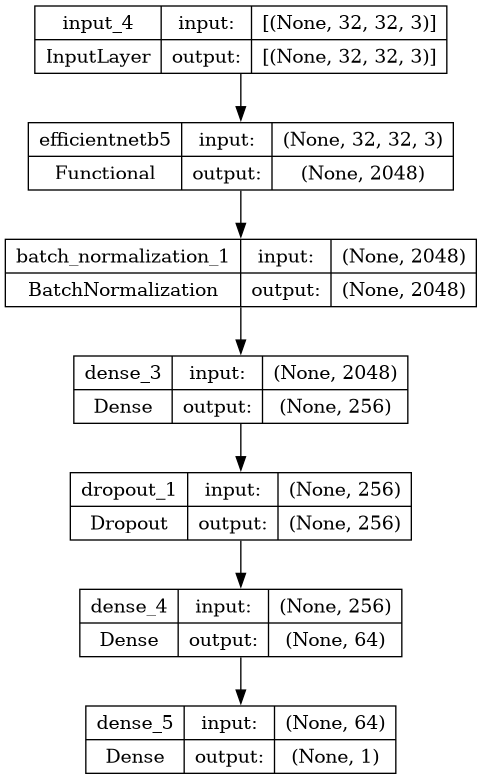

In [22]:
# Visualize the EfficientNetB5 model architecture
tf.keras.utils.plot_model(EfficientNet_model, show_shapes = True, to_file = 'EfficientNetB5_model.png')
Image('EfficientNetB5_model.png')


In [23]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using EfficientNetB5...")
EfficientNet_model_history = EfficientNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")


Starting training with Transfer Learning using EfficientNetB5...
Epoch 1/100
200/200 [==============================] - 302s 1s/step - loss: 1.2994 - accuracy: 0.9219 - precision_1: 0.9339 - recall_1: 0.9080 - val_loss: 0.6621 - val_accuracy: 0.8600 - val_precision_1: 0.9982 - val_recall_1: 0.7212
Epoch 2/100
200/200 [==============================] - 225s 1s/step - loss: 0.2121 - accuracy: 0.9711 - precision_1: 0.9717 - recall_1: 0.9705 - val_loss: 0.2707 - val_accuracy: 0.9570 - val_precision_1: 0.9910 - val_recall_1: 0.9223
Epoch 3/100
200/200 [==============================] - 224s 1s/step - loss: 0.1149 - accuracy: 0.9809 - precision_1: 0.9816 - recall_1: 0.9802 - val_loss: 0.1559 - val_accuracy: 0.9510 - val_precision_1: 0.9160 - val_recall_1: 0.9930
Epoch 4/100
200/200 [==============================] - 224s 1s/step - loss: 0.0790 - accuracy: 0.9876 - precision_1: 0.9878 - recall_1: 0.9874 - val_loss: 0.1903 - val_accuracy: 0.9515 - val_precision_1: 0.9170 - val_recall_1: 0.9929

In [24]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = EfficientNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")


40/40 [==============================] - 6s 137ms/step - loss: 0.0824 - accuracy: 0.9758 - precision_1: 0.9805 - recall_1: 0.9709
Val Loss: 0.0824
Val Accuracy: 0.9758
Val Precision: 0.9805
Val Recall: 0.9709


In [2]:
# Plot error rates and metric rates
plot_metrics(EfficientNet_model_history, 'loss')
plot_metrics(EfficientNet_model_history, 'accuracy')
plot_metrics(EfficientNet_model_history, 'precision')
plot_metrics(EfficientNet_model_history, 'recall')


NameError: name 'plot_metrics' is not defined

In [8]:
print("hello")

hello


In [9]:
# Building the Transfer Learning model using EfficientNetB6
EfficientNet_base_model = tf.keras.applications.EfficientNetB6(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
EfficientNet_base_model.trainable = True

# Create a new model on top of the EfficientNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = EfficientNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
EfficientNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
EfficientNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
EfficientNet_model.summary()


165234480/165234480 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb6 (Functional  (None, 2304)              40960143  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2304)              9216      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               590080    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                            

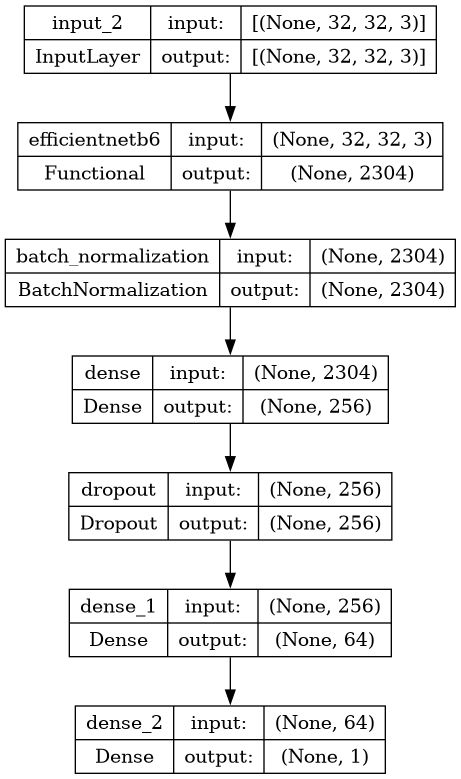

In [10]:
# Visualize the EfficientNetB6 model architecture
tf.keras.utils.plot_model(EfficientNet_model, show_shapes = True, to_file = 'EfficientNetB6_model.png')
Image('EfficientNetB6_model.png')


In [11]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using EfficientNetB6...")
EfficientNet_model_history = EfficientNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")


Starting training with Transfer Learning using EfficientNetB6...
Epoch 1/100


I0000 00:00:1711974231.896479     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 408s 1s/step - loss: 1.9458 - accuracy: 0.9326 - precision: 0.9311 - recall: 0.9344 - val_loss: 0.9950 - val_accuracy: 0.9217 - val_precision: 0.9915 - val_recall: 0.8507
Epoch 2/100
200/200 [==============================] - 295s 1s/step - loss: 0.4040 - accuracy: 0.9722 - precision: 0.9734 - recall: 0.9709 - val_loss: 0.3387 - val_accuracy: 0.9673 - val_precision: 0.9598 - val_recall: 0.9755
Epoch 3/100
200/200 [==============================] - 295s 1s/step - loss: 0.1660 - accuracy: 0.9804 - precision: 0.9811 - recall: 0.9797 - val_loss: 0.1838 - val_accuracy: 0.9542 - val_precision: 0.9217 - val_recall: 0.9929
Epoch 4/100
200/200 [==============================] - 295s 1s/step - loss: 0.0642 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - val_loss: 0.2391 - val_accuracy: 0.9456 - val_precision: 0.9947 - val_recall: 0.8960
Epoch 6/100
200/200 [==============================] - 295s 1s/step - loss: 0.0497 - accuracy: 0.9942 - prec

In [12]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = EfficientNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")


40/40 [==============================] - 8s 178ms/step - loss: 0.1094 - accuracy: 0.9732 - precision: 0.9839 - recall: 0.9620
Val Loss: 0.1094
Val Accuracy: 0.9732
Val Precision: 0.9839
Val Recall: 0.9620


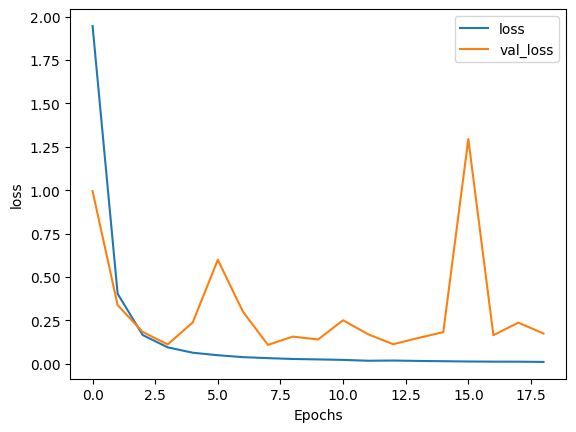

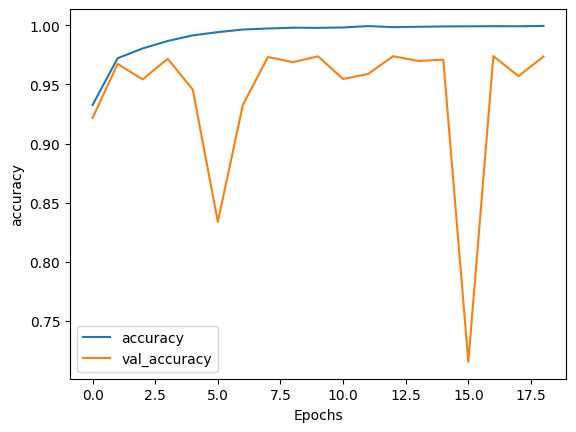

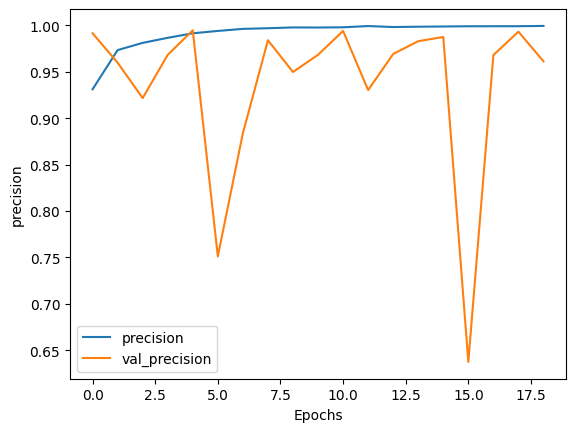

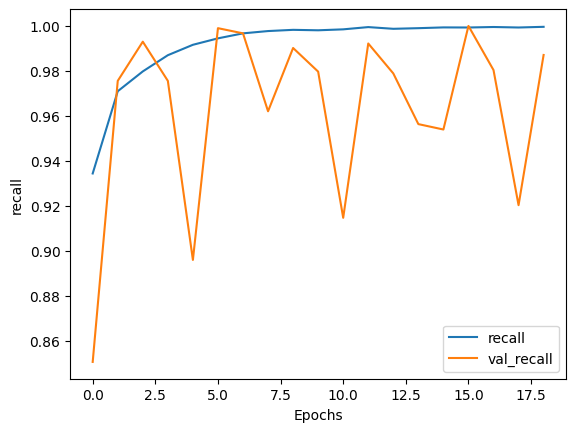

In [13]:
# Plot error rates and metric rates
plot_metrics(EfficientNet_model_history, 'loss')
plot_metrics(EfficientNet_model_history, 'accuracy')
plot_metrics(EfficientNet_model_history, 'precision')
plot_metrics(EfficientNet_model_history, 'recall')
